In [25]:
import sys
import numpy as np
import pandas as pd
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
import time
import random
import num2words
from torch.utils.data import Dataset, DataLoader

from constant import LETTER_LIST
from utils import *

# Load Data

In [3]:
from datasets import *
# Load data
sub_data_path = "./data/knnw_en_sub_labeled.csv"
sub_df = pd.read_table(sub_data_path, sep = ";", header=0)
# audio_path = "./knnw_en.log_spectrogram.npy"
audio_path = "./data/log_spectrogram.npy"
audio_data = np.load(audio_path).transpose()
print(sub_df.shape)
print(audio_data.shape)

(1393, 5)
(1370493, 129)


In [8]:
from preprocess import preprocess, get_letter_vocab

processed_df = preprocess(sub_df)
processed_df

Number of lines: 1393 -> 1291


,Number,Start time in ms,End time in ms,Text,Speaker Label,Processed Text,Transcript Indices
1,2,53940,58090,"Some mornings, I wake up crying without knowin...",Mitsuha,some mornings i wake up crying without knowing...,"[19, 15, 13, 5, 32, 13, 15, 18, 14, 9, 14, 7, ..."
2,3,58700,61440,That's when everything happens now and again.,Mitsuha,that's when everything happens now and again,"[20, 8, 1, 20, 28, 19, 32, 23, 8, 5, 14, 32, 5..."
3,4,62060,66540,"Whatever that dream was I had, I can never rem...",Taki,whatever that dream was i had i can never reme...,"[23, 8, 1, 20, 5, 22, 5, 18, 32, 20, 8, 1, 20,..."
4,5,66540,69550,- But... - But...,Taki+Mitsuha,but but,"[2, 21, 20, 32, 2, 21, 20, 33]"
5,6,69550,72190,the only thing that does last when I wake up,Mitsuha,the only thing that does last when i wake up,"[20, 8, 5, 32, 15, 14, 12, 25, 32, 20, 8, 9, 1..."
...,...,...,...,...,...,...,...
1388,1389,6363570,6367130,you refused but I saw them pouring down your f...,Band,you refused but i saw them pouring down your f...,"[25, 15, 21, 32, 18, 5, 6, 21, 19, 5, 4, 32, 2..."
1389,1390,6367130,6368820,"Crying even when I'm happy,",Band,crying even when i'm happy,"[3, 18, 25, 9, 14, 7, 32, 5, 22, 5, 14, 32, 23..."
1390,1391,6368820,6371440,smiling even when I'm feeling lonely!,Band,smiling even when i'm feeling lonely,"[19, 13, 9, 12, 9, 14, 7, 32, 5, 22, 5, 14, 32..."
1391,1392,6371440,6373430,It's because the heart of mine,Band,it's because the heart of mine,"[9, 20, 28, 19, 32, 2, 5, 3, 1, 21, 19, 5, 32,..."


# Data loader/set

In [14]:
from datasets import KnnwAudioDataset, collate


train_df, test_df = random_split(processed_df, 0.15, seed=10086)
print(train_df.shape, test_df.shape)


DATASET = KnnwAudioDataset

train_dataset = DATASET(audio_data, train_df, total_frames=len(audio_data))
test_dataset = DATASET(audio_data, test_df, total_frames=len(audio_data))

train_loader = DataLoader(train_dataset, 32, shuffle=True, collate_fn=collate,
                                num_workers=4,  pin_memory=True)
test_loader = DataLoader(test_dataset, 32, shuffle=False, collate_fn=collate,
                                num_workers=4, pin_memory=True)

train_df.iloc[:5]

(1098, 7) (193, 7)


,Number,Start time in ms,End time in ms,Text,Speaker Label,Processed Text,Transcript Indices
991,992,4725760,4727000,Taki!,Mitsuha,taki,"[20, 1, 11, 9, 33]"
708,709,3370320,3371690,Maybe if I could-,Taki,maybe if i could,"[13, 1, 25, 2, 5, 32, 9, 6, 32, 9, 32, 3, 15, ..."
269,270,1302170,1304260,-And where's your lunch?,Tsukasa,and where's your lunch,"[1, 14, 4, 32, 23, 8, 5, 18, 5, 28, 19, 32, 25..."
563,564,2781940,2784530,What are you doing here?,Taki,what are you doing here,"[23, 8, 1, 20, 32, 1, 18, 5, 32, 25, 15, 21, 3..."
104,105,507510,508970,"Well, that's the mayor for ya.",BystanderD,well that's the mayor for ya,"[23, 5, 12, 12, 32, 20, 8, 1, 20, 28, 19, 32, ..."


# Spectrogram vs Transcript

In [16]:
sample_spect, sample_trans_index, _, _ = next(iter(train_loader))
sample_trans = index_to_transcripts(sample_trans_index)

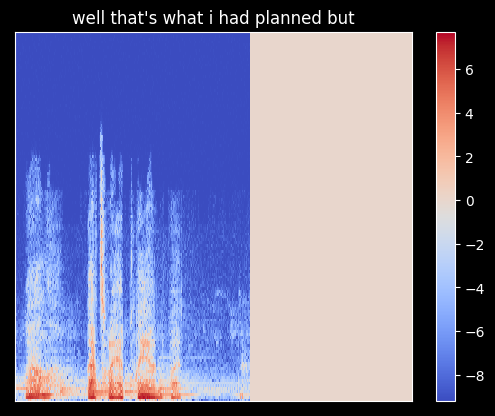

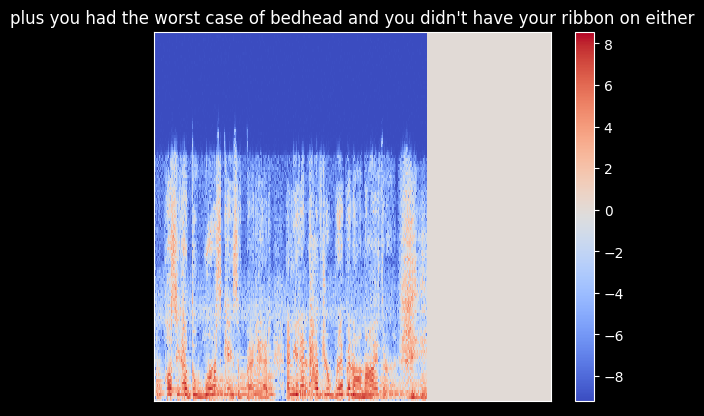

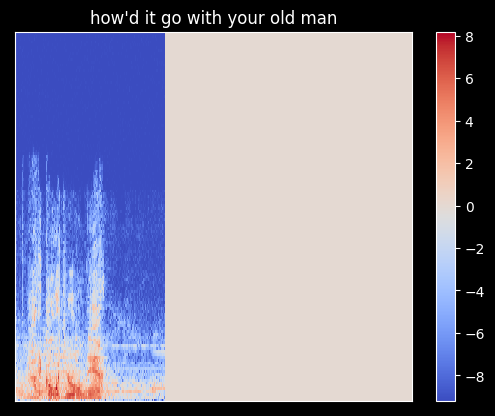

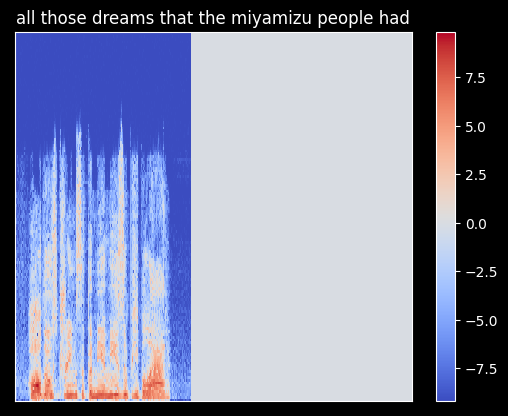

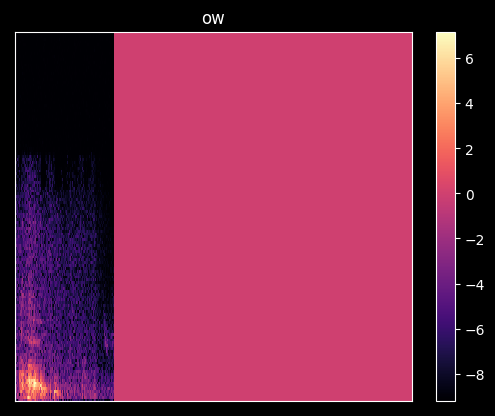

In [30]:
for i in range(5): 
    plot_spectrogram(sample_spect[i].numpy(), sample_trans[i])

# Data Augmentation

In [28]:
X, Y, x_lens, y_lens = next(iter(train_loader))
Y_trans = index_to_transcripts(sample_trans_index)

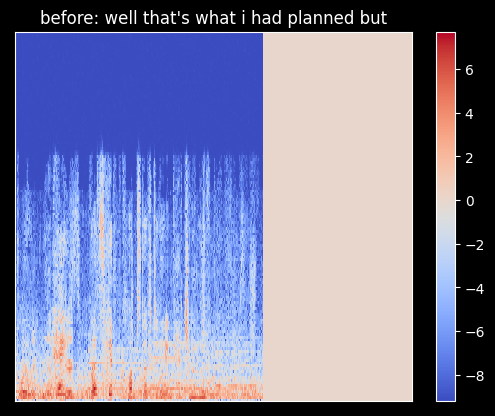

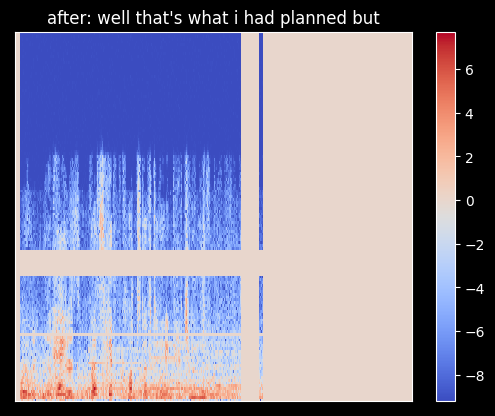

In [29]:
from data_augment import specaugment

sample_one_spect = X[0]
sample_one_trans = Y_trans[0]
sample_one_spect_len = x_lens[0]

plot_spectrogram(sample_one_spect.cpu().numpy(), "before: "+sample_one_trans)
sample_one_spect_aug = specaugment(sample_one_spect, sample_one_spect_len)
plot_spectrogram(sample_one_spect_aug.cpu().numpy(), "after: "+sample_one_trans)